# Sensor fotônico
#### Bovine Brucellosis (Bactéria)

Análise das imagens de um sensor fotônico (guia de onda) para a detecção de uma bactéria através dos pontos de espalhamento gerados no processo de decantação

***
#### **Mestranda**
Bianca Tieppo
***
#### Orientação
Profa. Dra. Lúcia Akemi Miyazato Saito (UPM)
<br>Profa. Dra. Daniella Lopez Vale (UFRJ)
***

#### Treinamento do MLP e análises

In [1]:
# Importar as bibliotecas padrões
%matplotlib inline 

import datetime
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import os
import seaborn as sn
import shutil

# Bibliotecas RNA
from graphviz import Digraph
from scipy.stats import pointbiserialr
from sklearn.metrics import (accuracy_score, 
                             brier_score_loss,
                             classification_report, 
                             confusion_matrix, 
                             f1_score,
                             log_loss,
                             make_scorer,
                             mean_squared_error, 
                             precision_score,
                             r2_score, 
                             recall_score, 
                             roc_auc_score)
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, learning_curve, train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def current_path(): 
    print("Current working directory") 
    print(os.getcwd()) 
    print() 
  
current_path() 
os.chdir(r'C:\Users\Bruno\Processamento\BBD_Dataframe_vs7') 
current_path() 

Current working directory
C:\Users\Bruno\Processamento

Current working directory
C:\Users\Bruno\Processamento\BBD_Dataframe_vs7



In [3]:
df = pd.read_excel("Data_BBD7-2.xlsx", index_col = 0)

In [4]:
df

Chip Nome da amostra         Data e hora       Data  \
0    01-03-23_positive1        6min.jpg 2023-03-01 13:56:20 2023-03-01   
1    01-03-23_positive1       10min.jpg 2023-03-01 14:00:14 2023-03-01   
2    01-03-23_positive1       18min.jpg 2023-03-01 14:08:40 2023-03-01   
3    01-03-23_positive1       25min.jpg 2023-03-01 14:15:02 2023-03-01   
4    01-03-23_positive1       30min.jpg 2023-03-01 14:20:04 2023-03-01   
..                  ...             ...                 ...        ...   
713  04-07-23_negative2      109min.jpg 2023-07-04 17:18:22 2023-07-04   
714  04-07-23_negative2      112min.jpg 2023-07-04 17:21:28 2023-07-04   
715  04-07-23_negative2      115min.jpg 2023-07-04 17:24:06 2023-07-04   
716  04-07-23_negative2      118min.jpg 2023-07-04 17:27:18 2023-07-04   
717  04-07-23_negative2      121min.jpg 2023-07-04 17:30:24 2023-07-04   

      Horário  Tempo       Matiz   Saturação      Valor  Área total  \
0    13:56:20      6  129.171875  245.945849  77.367111         0.0   
1    14:00:14      9  135.249566  246.915191  77.204861         0.0   
2    14:08:40     18  134.105655  247.956194  90.288039         0.0   
3    14:15:02     24  129.186734  247.872472  89.540058         0.0   
4    14:20:04     29  120.984681  246.438879  81.754596         0.0   
..        ...    ...         ...         ...        ...         ...   
713  17:18:22    111    9.635163  218.942298  16.170706         0.0   
714  17:21:28    115   10.991146  217.809718  17.129386         0.0   
715  17:24:06    117    8.784060  226.941886  49.725809         0.0   
716  17:27:18    120   12.070964  225.428971  48.702734         0.0   
717  17:30:24    123   11.775846  225.479167  47.067839         0.0   

     Número de pontos (contorno)  Número de pontos (LoG)  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
..                           ...                     ...   
713                            0                       0   
714                            0                       0   
715                            0                       0   
716                            0                       0   
717                            0                       0   

     Número de pontos (DoG)  Número de pontos (DoH)      Alvo  
0                         0                       0  Positive  
1                         0                       0  Positive  
2                         0                       0  Positive  
3                         0                       0  Positive  
4                         0                       0  Positive  
..                      ...                     ...       ...  
713                       0                       0  Negative  
714                       0                       0  Negative  
715                       0                       0  Negative  
716                       0                       0  Negative  
717                       0                       0  Negative  

[718 rows x 15 columns]

In [5]:
df_rna = df.copy()
df_rna = df_rna.drop(['Chip', 'Nome da amostra', 'Data e hora', 'Data', 'Horário', 'Tempo'], axis = 1)
df_rna['Alvo'] = df_rna['Alvo'].map({'Positive': 1, 'Negative': 0})

In [6]:
df_rna.head()

Matiz   Saturação      Valor  Área total  Número de pontos (contorno)  \
0  129.171875  245.945849  77.367111         0.0                            0   
1  135.249566  246.915191  77.204861         0.0                            0   
2  134.105655  247.956194  90.288039         0.0                            0   
3  129.186734  247.872472  89.540058         0.0                            0   
4  120.984681  246.438879  81.754596         0.0                            0   

   Número de pontos (LoG)  Número de pontos (DoG)  Número de pontos (DoH)  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   

   Alvo  
0     1  
1     1  
2     1  
3     1  
4     1

In [7]:
# Definição das variáveis
y = df_rna.Alvo
X = df_rna.drop('Alvo',axis=1)

In [8]:
# Divisão dos dados para treinamento e teste - função train_test_split(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((574, 8), (574,), (144, 8), (144,))

In [10]:
# Normalização apenas nos dados de treinamento
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)

In [11]:
# Aplicação da mesma normalização nos dados de teste
X_test_normalized = scaler.transform(X_test)

In [12]:
modelRNA_Classifier = MLPClassifier(activation='identity', alpha=0.0001, hidden_layer_sizes=(200,), learning_rate='constant', solver='lbfgs', max_iter=1800)
#modelRNA_Classifier = MLPClassifier(activation='identity', alpha=0.005, hidden_layer_sizes=(110,), learning_rate='adaptive', solver='lbfgs', max_iter=1500)

In [13]:
modelRNA_Classifier = modelRNA_Classifier.fit(X_train, y_train)

In [14]:
coeficientes = modelRNA_Classifier.coefs_

In [17]:
# Previsão para amostras de treinamento
y_train_predict_Classifier = modelRNA_Classifier.predict(X_train)

# Previsão para amostras de teste
y_test_predict_Classifier = modelRNA_Classifier.predict(X_test)

In [18]:
train_accuracy_Classifier = accuracy_score(y_train, y_train_predict_Classifier)
test_accuracy_Classifier = accuracy_score(y_test, y_test_predict_Classifier)

confusion_matrix_train_Classifier = confusion_matrix(y_train, y_train_predict_Classifier)
confusion_matrix_test_Classifier = confusion_matrix(y_test, y_test_predict_Classifier)

recall_train_Classifier = recall_score(y_train, y_train_predict_Classifier)
recall_test_Classifier = recall_score(y_test, y_test_predict_Classifier)

precision_train_Classifier = precision_score(y_train, y_train_predict_Classifier)
precision_test_Classifier = precision_score(y_test, y_test_predict_Classifier)

ROC_train_Classifier = roc_auc_score(y_train, y_train_predict_Classifier)
ROC_test_Classifier = roc_auc_score(y_test, y_test_predict_Classifier)

F1_train_Classifier = f1_score(y_train, y_train_predict_Classifier)
F1_test_Classifier = f1_score(y_test, y_test_predict_Classifier)

loss_train_Classifier = brier_score_loss(y_train, y_train_predict_Classifier)
loss_test_Classifier = brier_score_loss(y_test, y_test_predict_Classifier)

In [19]:
confusion_matrix_train_Classifier

array([[246,  37],
       [ 59, 232]], dtype=int64)

In [20]:
parameters_training_Classifier = pd.DataFrame({'Parameter': 'Training', 'Accuracy': train_accuracy_Classifier, 'Precision': precision_train_Classifier, 'ROC': ROC_train_Classifier, 'Seletive': recall_train_Classifier, 'Loss': loss_train_Classifier}, index=[0])
parameters_test_Classifier = pd.DataFrame({'Parameter': 'Test', 'Accuracy': test_accuracy_Classifier, 'Precision': precision_test_Classifier, 'ROC': ROC_test_Classifier, 'Seletive': recall_test_Classifier, 'Loss': loss_test_Classifier}, index=[0])

# Transformação dos dados do modelo em arquivo
parametersdata_Classifier = pd.concat([parameters_training_Classifier, parameters_test_Classifier])

parametersdata_Classifier

Parameter  Accuracy  Precision       ROC  Seletive      Loss
0  Training  0.832753   0.862454  0.833254  0.797251  0.167247
0      Test  0.812500   0.876712  0.817663  0.780488  0.187500

#### Validação Cruzada

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Definindo o número de folds
num_folds = 20

# Criando os objetos K-Fold e realizando o cross-validation
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 42)
cross_val_scores = cross_val_score(modelRNA_Classifier, X_scaled, y, cv = kf)

# Cross-validation
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean accuracy: {cross_val_scores.mean()}")

Cross-validation scores: [0.88888889 0.80555556 0.75       0.97222222 0.91666667 0.86111111
 0.86111111 0.77777778 0.91666667 0.86111111 0.77777778 0.86111111
 0.77777778 0.72222222 0.80555556 0.80555556 0.77777778 0.77777778
 0.77142857 0.77142857]
Mean accuracy: 0.8229761904761906


In [24]:
# Pontuações média e desvio padrão
print("Scores:", cross_val_scores)
print("Média das pontuações:", np.mean(cross_val_scores ))
print("Desvio padrão das pontuações:", np.std(cross_val_scores))

Scores: [0.88888889 0.80555556 0.75       0.97222222 0.91666667 0.86111111
 0.86111111 0.77777778 0.91666667 0.86111111 0.77777778 0.86111111
 0.77777778 0.72222222 0.80555556 0.80555556 0.77777778 0.77777778
 0.77142857 0.77142857]
Média das pontuações: 0.8229761904761906
Desvio padrão das pontuações: 0.06399526537900835


#### Significância das variáveis na acurácia e precisão do modelo

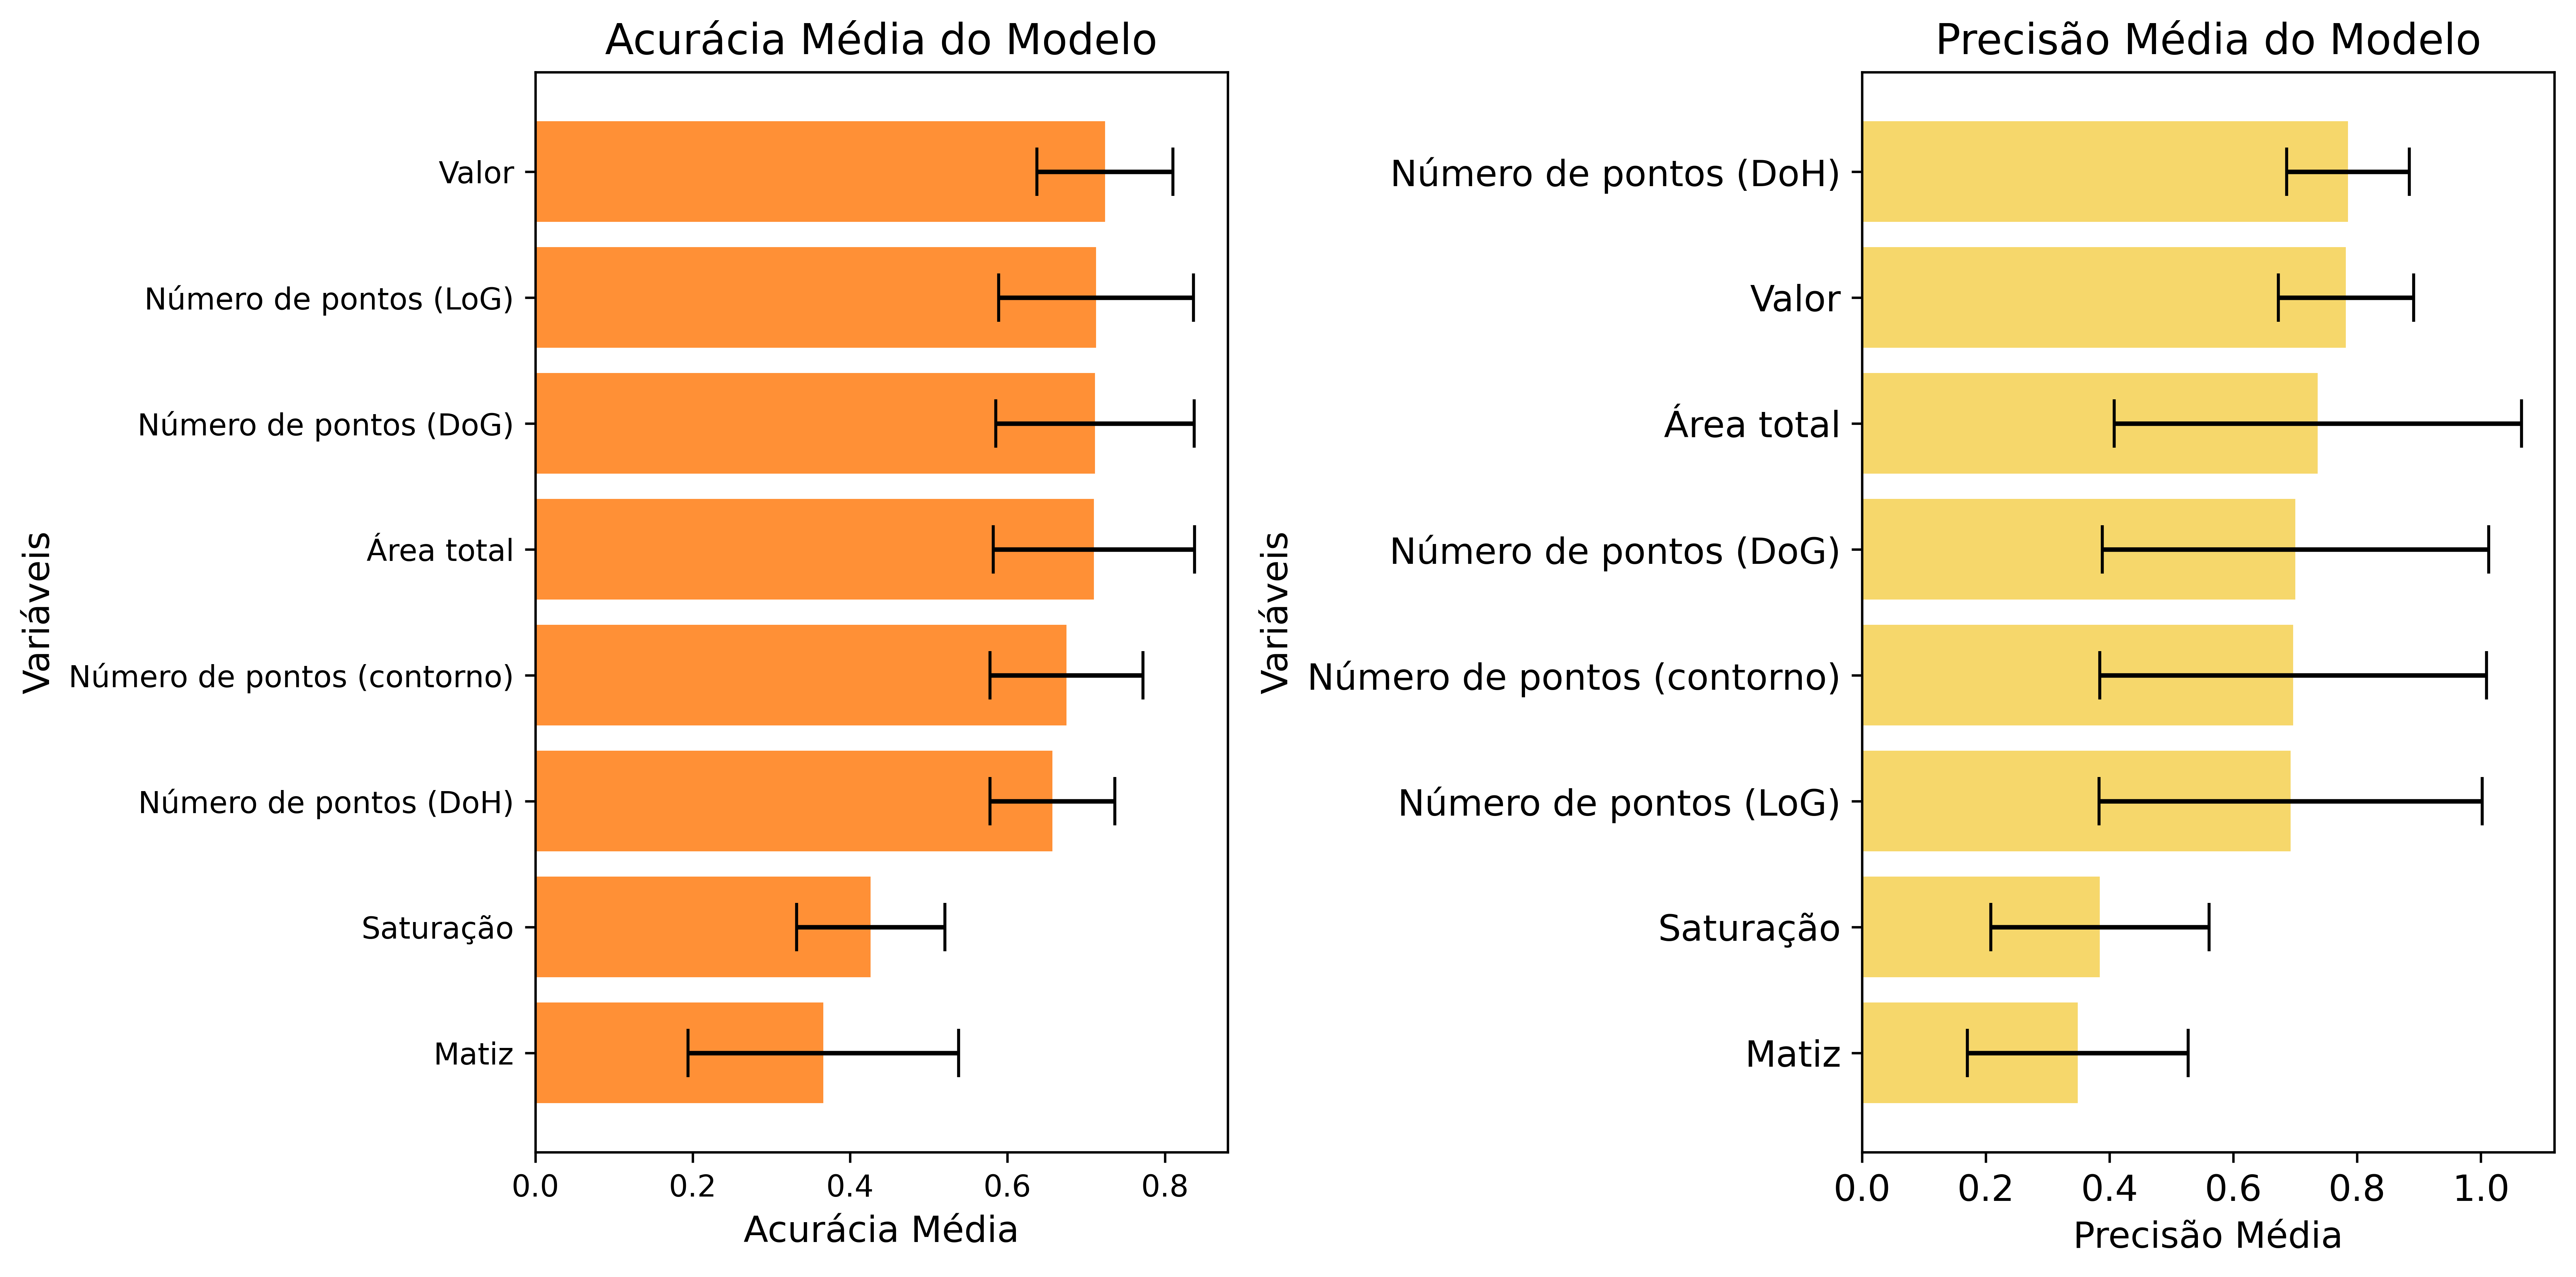

In [55]:
# Definindo as variáveis
variables = ['Matiz', 'Saturação', 'Valor', 'Área total', 'Número de pontos (contorno)', 'Número de pontos (LoG)', 'Número de pontos (DoG)', 'Número de pontos (DoH)']

# Lista para armazenar as médias e os intervalos de confiança da acurácia e precisão
mean_accuracies = []
mean_precisions = []
confidence_intervals_acc = []
confidence_intervals_prec = []

# Calculando acurácia e precisão para cada variável
for var in variables:
    # Selecionando apenas a coluna correspondente à variável atual
    X_var = X_scaled[:, variables.index(var)].reshape(-1, 1)
    
    precision_scorer = make_scorer(precision_score, zero_division = 0)
    
    # Calculando a acurácia e a precisão usando cross-validation
    scores_acc = cross_val_score(modelRNA_Classifier, X_var, y, cv = 5, scoring = 'accuracy')
    scores_prec = cross_val_score(modelRNA_Classifier, X_var, y, cv = 5, scoring = precision_scorer)
    
    # Calculando a média da acurácia e precisão
    mean_accuracy = np.mean(scores_acc)
    mean_precision = np.mean(scores_prec)
    mean_accuracies.append(mean_accuracy)
    mean_precisions.append(mean_precision)
    
    # Calculando o intervalo de confiança (95%) para acurácia
    std_dev_acc = np.std(scores_acc)
    conf_interval_acc = 1.96 * (std_dev_acc / np.sqrt(len(scores_acc)))
    confidence_intervals_acc.append(conf_interval_acc)
    
    # Calculando o intervalo de confiança (95%) para precisão
    std_dev_prec = np.std(scores_prec)
    conf_interval_prec = 1.96 * (std_dev_prec / np.sqrt(len(scores_prec)))
    confidence_intervals_prec.append(conf_interval_prec)

# Ordenando as variáveis pela acurácia média (do maior para o menor)
sorted_indices_acc = np.argsort(mean_accuracies)[::-1]  # Obtendo índices ordenados
# Ordenando as variáveis pela precisão média (do maior para o menor)
sorted_indices_prec = np.argsort(mean_precisions)[::-1]  # Obtendo índices ordenados

sorted_variables_acc = [variables[i] for i in sorted_indices_acc]
sorted_accuracies = [mean_accuracies[i] for i in sorted_indices_acc]
sorted_intervals_acc = [confidence_intervals_acc[i] for i in sorted_indices_acc]

sorted_variables_prec = [variables[i] for i in sorted_indices_prec]
sorted_precisions = [mean_precisions[i] for i in sorted_indices_prec]
sorted_intervals_prec = [confidence_intervals_prec[i] for i in sorted_indices_prec]

# Cores
orange = '#ff9036'
yellow = '#f6d76b'

# Plotando os subplots (gráficos de acurácia e precisão lado a lado)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), dpi = 600)

# Aumentando o tamanho dos números nos eixos x e y
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)

# Gráfico de acurácia
ax1.barh(sorted_variables_acc, sorted_accuracies, xerr=sorted_intervals_acc, capsize = 8, color = orange)
ax1.set_xlabel('Acurácia Média', fontsize = 12)
ax1.set_ylabel('Variáveis', fontsize = 12)
ax1.set_title('Acurácia Média do Modelo', fontsize = 14)
ax1.invert_yaxis()

# Aumentando o tamanho dos números nos eixos x e y
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)

# Gráfico de precisão
ax2.barh(sorted_variables_prec, sorted_precisions, xerr=sorted_intervals_prec, capsize=8, color=yellow)
ax2.set_xlabel('Precisão Média', fontsize = 12)
ax2.set_ylabel('Variáveis', fontsize = 12)
ax2.set_title('Precisão Média do Modelo', fontsize = 14)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

#### Média das variáveis normalizadas

In [26]:
df_mean = df.copy()
df_mean = df_mean.drop(['Chip', 'Nome da amostra', 'Data e hora', 'Data', 'Horário', 'Tempo'], axis = 1)
df_mean

Matiz   Saturação      Valor  Área total  \
0    129.171875  245.945849  77.367111         0.0   
1    135.249566  246.915191  77.204861         0.0   
2    134.105655  247.956194  90.288039         0.0   
3    129.186734  247.872472  89.540058         0.0   
4    120.984681  246.438879  81.754596         0.0   
..          ...         ...        ...         ...   
713    9.635163  218.942298  16.170706         0.0   
714   10.991146  217.809718  17.129386         0.0   
715    8.784060  226.941886  49.725809         0.0   
716   12.070964  225.428971  48.702734         0.0   
717   11.775846  225.479167  47.067839         0.0   

     Número de pontos (contorno)  Número de pontos (LoG)  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
..                           ...                     ...   
713                            0                       0   
714                            0                       0   
715                            0                       0   
716                            0                       0   
717                            0                       0   

     Número de pontos (DoG)  Número de pontos (DoH)      Alvo  
0                         0                       0  Positive  
1                         0                       0  Positive  
2                         0                       0  Positive  
3                         0                       0  Positive  
4                         0                       0  Positive  
..                      ...                     ...       ...  
713                       0                       0  Negative  
714                       0                       0  Negative  
715                       0                       0  Negative  
716                       0                       0  Negative  
717                       0                       0  Negative  

[718 rows x 9 columns]

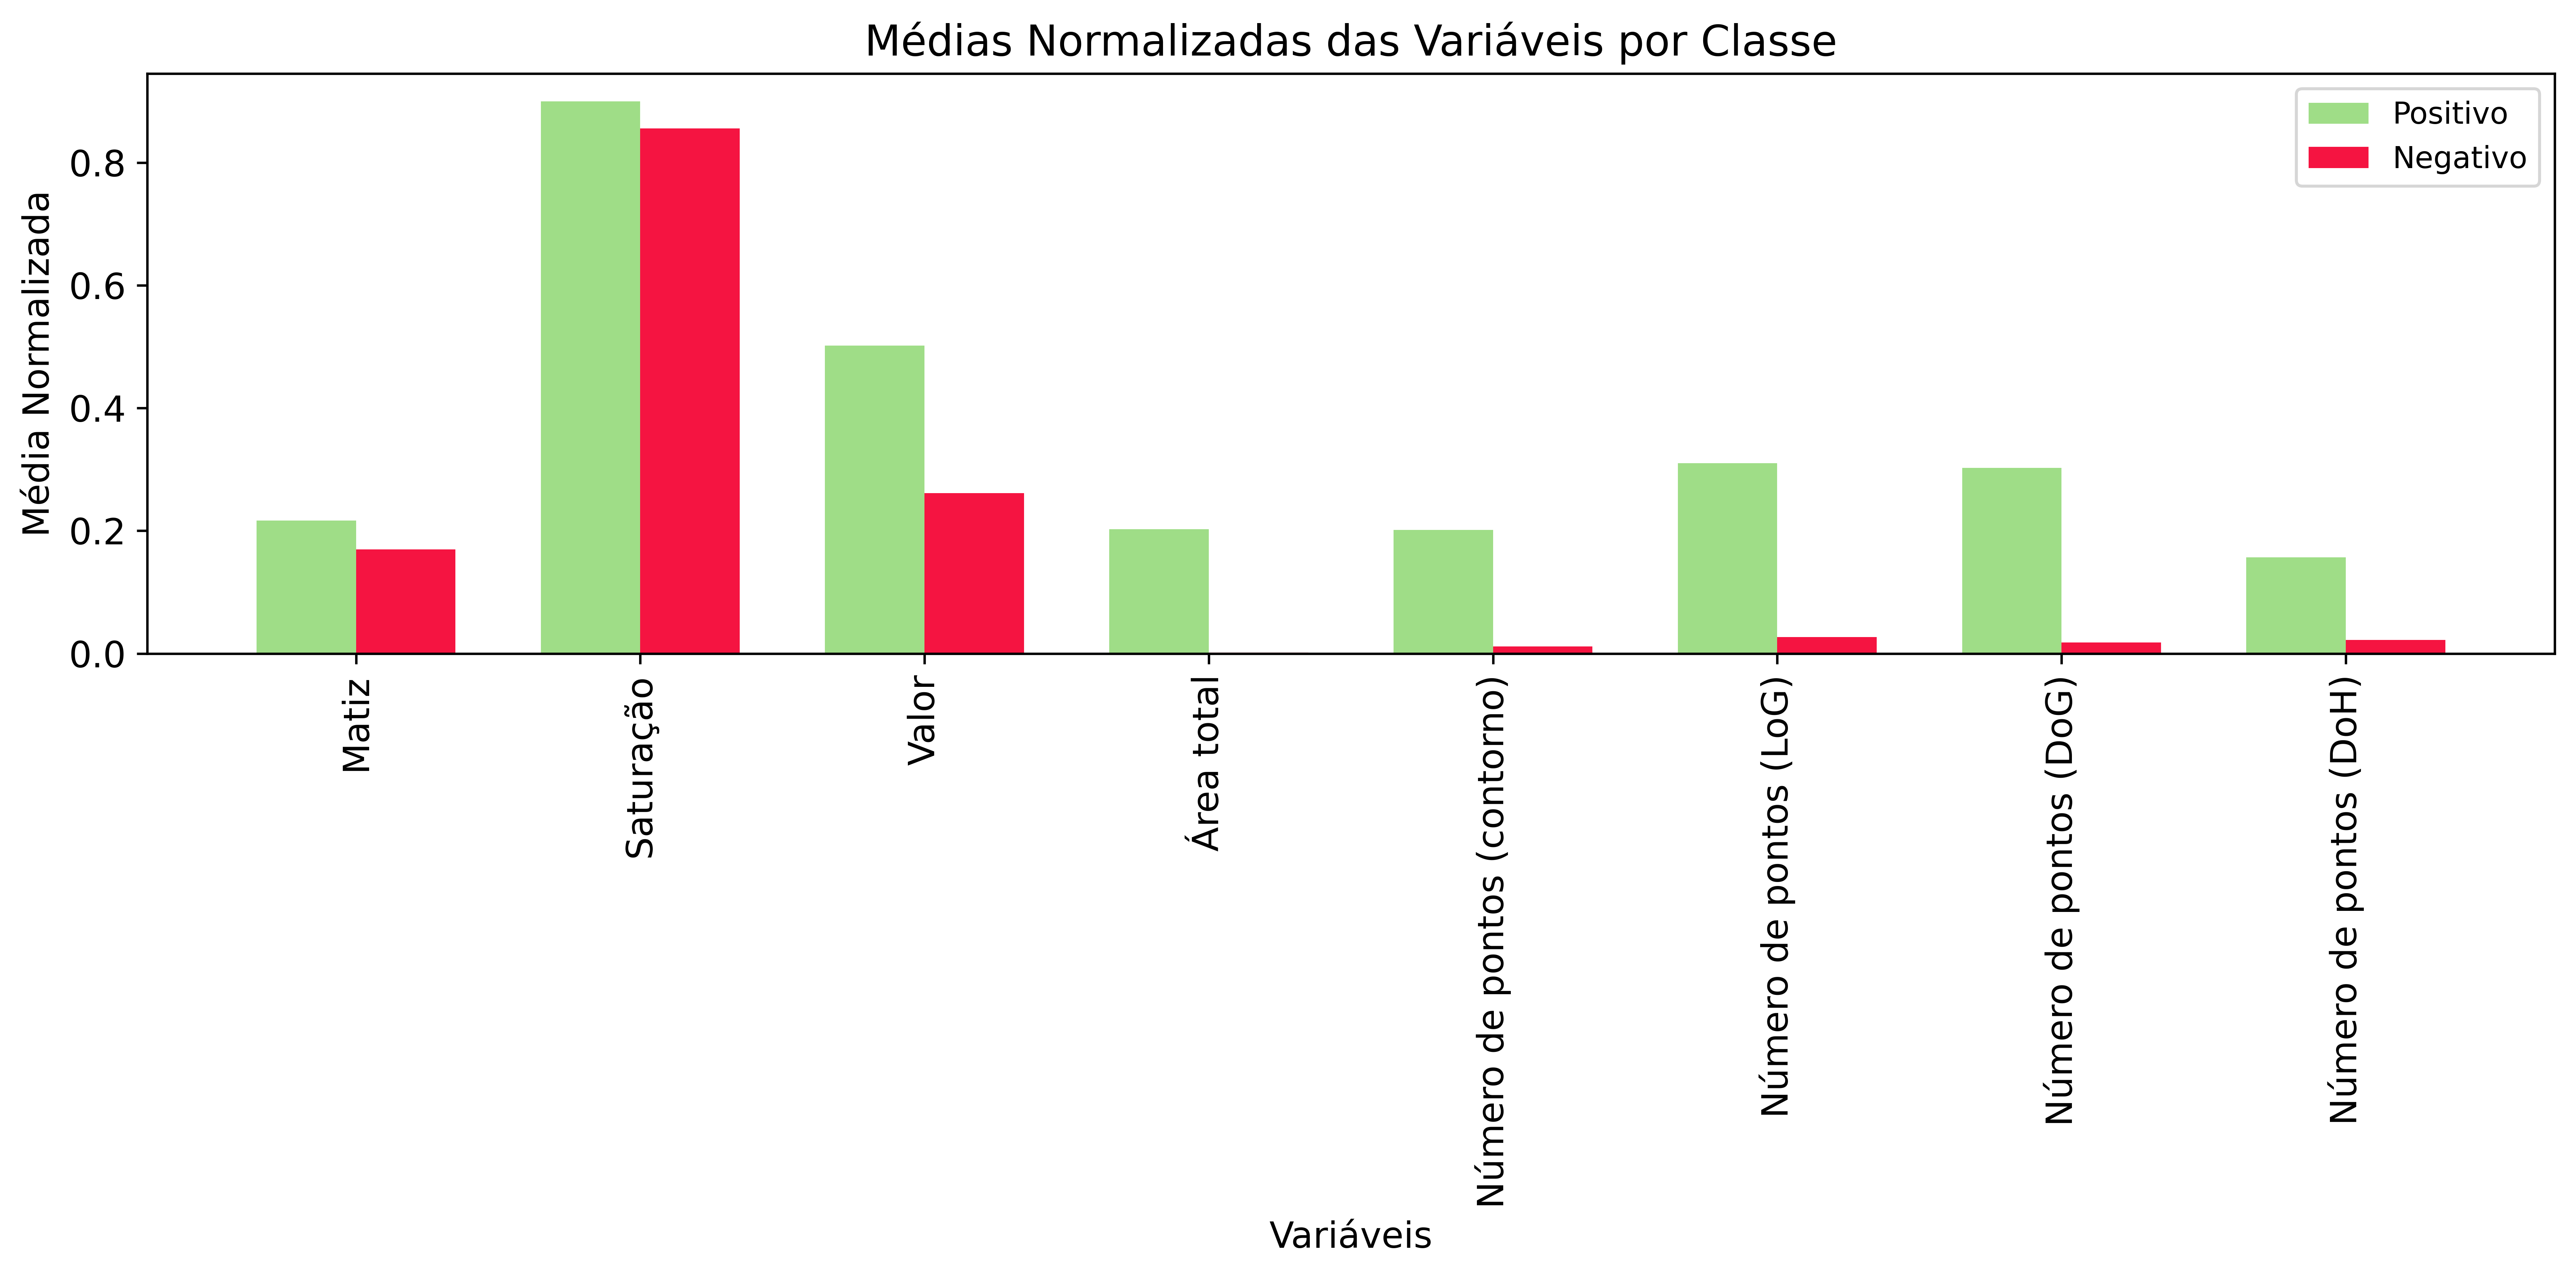

In [47]:
# Selecionar as colunas de variáveis e a coluna alvo
features = ['Matiz', 'Saturação', 'Valor', 'Área total', 'Número de pontos (contorno)', 'Número de pontos (LoG)', 'Número de pontos (DoG)', 'Número de pontos (DoH)']
target = 'Alvo'

# Normalizar os dados das variáveis
scaler = MinMaxScaler()
df_mean[features] = scaler.fit_transform(df_mean[features])

# Separar os dados em duas classes com base na variável alvo
positive_class = df_mean[df_mean[target] == 'Positive']
negative_class = df_mean[df_mean[target] == 'Negative']

# Calcular as médias das variáveis normalizadas para cada classe
positive_means = positive_class[features].mean()
negative_means = negative_class[features].mean()

# Plotar o gráfico de barras das médias normalizadas para as duas classes
# Definir a largura das barras
bar_width = 0.35

# Criar a posição das barras para 'positivo' e 'negativo'
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

# Cores
green = '#9fdd87'
red = '#f51441'

# Plotar o gráfico de barras das médias normalizadas para as duas classes
plt.figure(figsize = (12, 6), dpi = 600)

plt.bar(r1, positive_means, color=green, width=bar_width, label = 'Positivo')
plt.bar(r2, negative_means, color=red, width=bar_width, label = 'Negativo')

# Aumentando o tamanho dos números nos eixos x e y
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)

plt.xlabel('Variáveis', fontsize = 12)
plt.ylabel('Média Normalizada', fontsize = 12)
plt.title('Médias Normalizadas das Variáveis por Classe', fontsize = 14)
plt.xticks([r + bar_width / 2 for r in range(len(features))], features, rotation = 90)
plt.legend()
plt.tight_layout()

plt.show()

#### Média e variância para as variáveis mais significativas no modelo

In [48]:
df_mean_var = df.copy()
df_mean_var = df_mean_var.drop(['Chip', 'Nome da amostra', 'Data e hora', 'Data', 'Horário'], axis=1)
df_mean_var

Tempo       Matiz   Saturação      Valor  Área total  \
0        6  129.171875  245.945849  77.367111         0.0   
1        9  135.249566  246.915191  77.204861         0.0   
2       18  134.105655  247.956194  90.288039         0.0   
3       24  129.186734  247.872472  89.540058         0.0   
4       29  120.984681  246.438879  81.754596         0.0   
..     ...         ...         ...        ...         ...   
713    111    9.635163  218.942298  16.170706         0.0   
714    115   10.991146  217.809718  17.129386         0.0   
715    117    8.784060  226.941886  49.725809         0.0   
716    120   12.070964  225.428971  48.702734         0.0   
717    123   11.775846  225.479167  47.067839         0.0   

     Número de pontos (contorno)  Número de pontos (LoG)  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
..                           ...                     ...   
713                            0                       0   
714                            0                       0   
715                            0                       0   
716                            0                       0   
717                            0                       0   

     Número de pontos (DoG)  Número de pontos (DoH)      Alvo  
0                         0                       0  Positive  
1                         0                       0  Positive  
2                         0                       0  Positive  
3                         0                       0  Positive  
4                         0                       0  Positive  
..                      ...                     ...       ...  
713                       0                       0  Negative  
714                       0                       0  Negative  
715                       0                       0  Negative  
716                       0                       0  Negative  
717                       0                       0  Negative  

[718 rows x 10 columns]

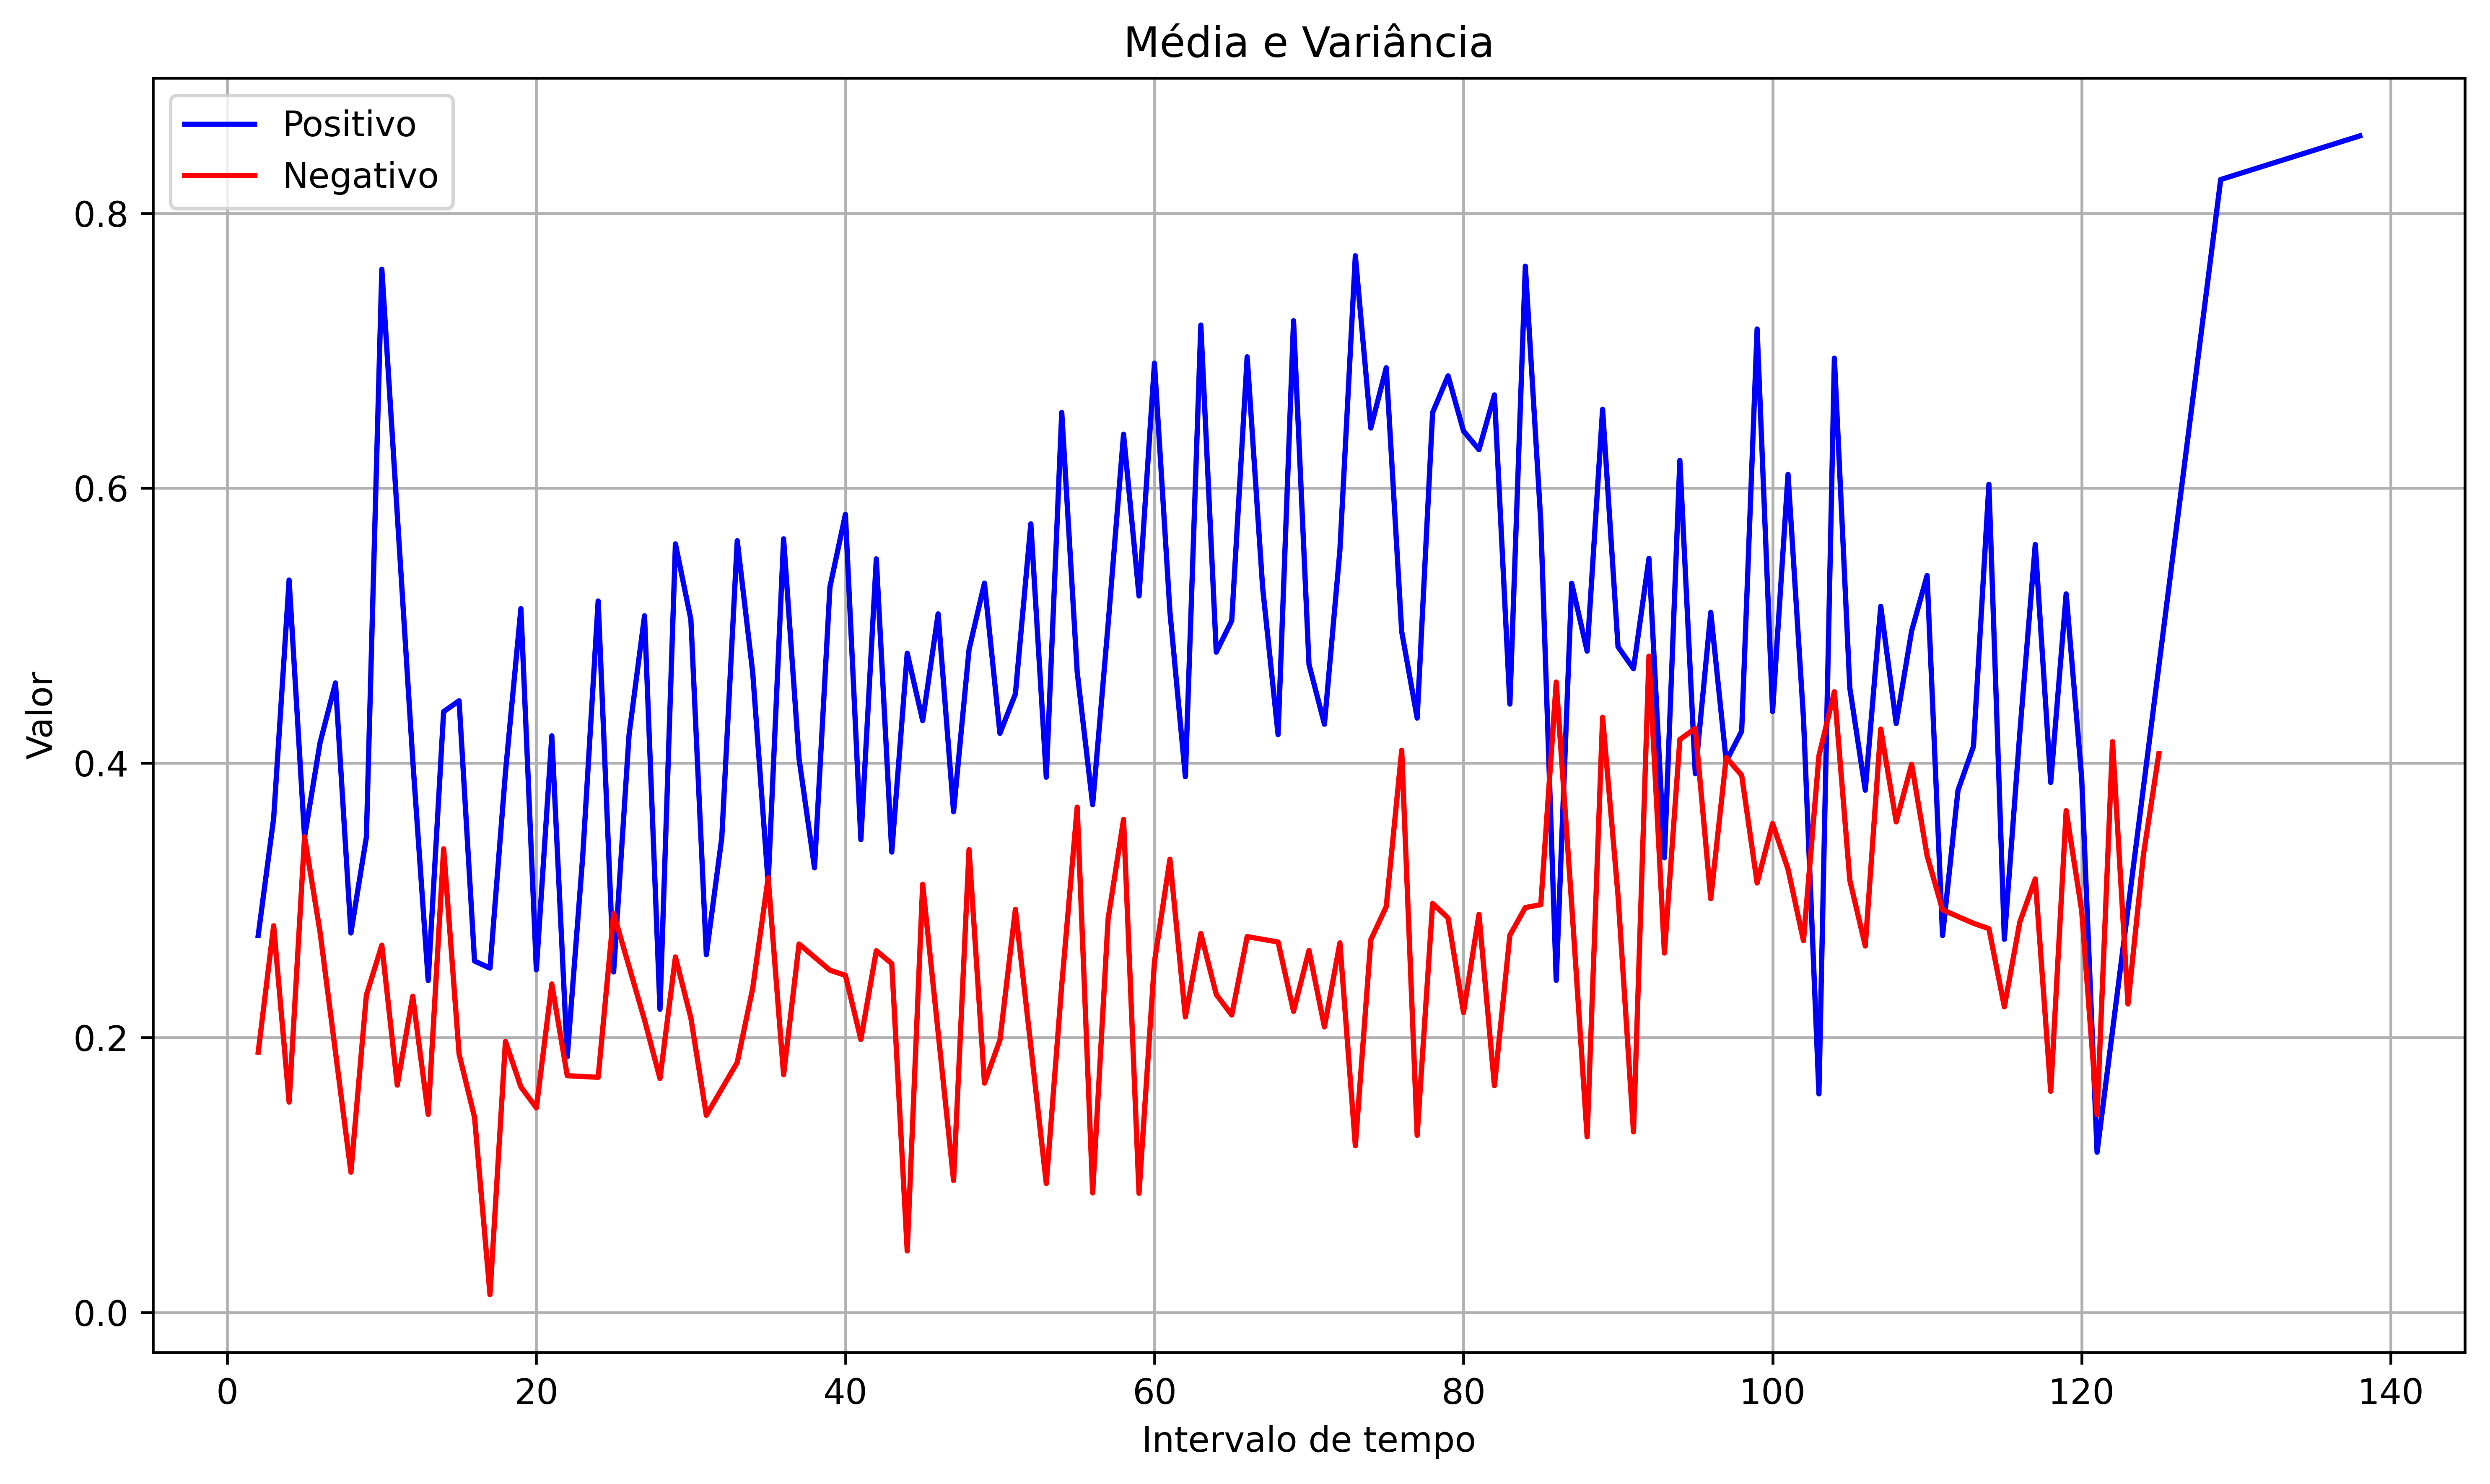

In [49]:
# Selecionar as colunas de variáveis e a coluna alvo
features = ['Matiz', 'Saturação', 'Valor', 'Área total', 'Número de pontos (contorno)', 'Número de pontos (LoG)', 'Número de pontos (DoG)', 'Número de pontos (DoH)']

# Normalizar os dados das variáveis
scaler = MinMaxScaler()
df_mean_var[features] = scaler.fit_transform(df_mean_var[features])

# Filtrar os dados para as classes Positive e Negative
positive_data = df_mean_var[df_mean_var['Alvo'] == 'Positive']
negative_data = df_mean_var[df_mean_var['Alvo'] == 'Negative']

# Calcular média e variância para ValueV em relação ao Time_Sample para as duas classes
positive_mean = positive_data.groupby('Tempo')['Valor'].mean()
positive_var = positive_data.groupby('Tempo')['Valor'].var()

negative_mean = negative_data.groupby('Tempo')['Valor'].mean()
negative_var = negative_data.groupby('Tempo')['Valor'].var()

# Plotar o gráfico de linhas para média e variância de ValueV em relação ao Time_Sample
plt.figure(figsize = (10, 6), dpi = 600)

plt.plot(positive_mean, label = 'Positivo', color = 'blue')
plt.plot(negative_mean, label = 'Negativo', color = 'red')

#plt.fill_between(positive_var.index, positive_mean - positive_var, positive_mean + positive_var, alpha=0.3, color='blue')
#plt.fill_between(negative_var.index, negative_mean - negative_var, negative_mean + negative_var, alpha=0.3, color='red')

plt.xlabel('Intervalo de tempo')
plt.ylabel('Valor')
plt.title('Média e Variância')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [50]:
# Definir os limites dos intervalos desejados
intervalos = list(range(0, 135, 5)) + [float('inf')]

# Criar os rótulos para os intervalos
rotulos = [f"Até {limite} min" if limite != float('inf') else f"Acima de {intervalos[-2]} min" for limite in intervalos[1:]]
df_mean_var['Intervalo de tempo'] = pd.cut(df_mean_var['Tempo'], bins = intervalos, labels = rotulos, right=False)

In [51]:
df_mean_var

Tempo     Matiz  Saturação     Valor  Área total  \
0        6  0.930099   0.969622  0.446149         0.0   
1        9  0.975293   0.974208  0.445155         0.0   
2       18  0.966787   0.979134  0.525288         0.0   
3       24  0.930209   0.978738  0.520707         0.0   
4       29  0.869218   0.971955  0.473022         0.0   
..     ...       ...        ...       ...         ...   
713    111  0.041207   0.841845  0.071328         0.0   
714    115  0.051290   0.836486  0.077199         0.0   
715    117  0.034878   0.879698  0.276849         0.0   
716    120  0.059320   0.872539  0.270583         0.0   
717    123  0.057125   0.872776  0.260569         0.0   

     Número de pontos (contorno)  Número de pontos (LoG)  \
0                            0.0                     0.0   
1                            0.0                     0.0   
2                            0.0                     0.0   
3                            0.0                     0.0   
4                            0.0                     0.0   
..                           ...                     ...   
713                          0.0                     0.0   
714                          0.0                     0.0   
715                          0.0                     0.0   
716                          0.0                     0.0   
717                          0.0                     0.0   

     Número de pontos (DoG)  Número de pontos (DoH)      Alvo  \
0                       0.0                     0.0  Positive   
1                       0.0                     0.0  Positive   
2                       0.0                     0.0  Positive   
3                       0.0                     0.0  Positive   
4                       0.0                     0.0  Positive   
..                      ...                     ...       ...   
713                     0.0                     0.0  Negative   
714                     0.0                     0.0  Negative   
715                     0.0                     0.0  Negative   
716                     0.0                     0.0  Negative   
717                     0.0                     0.0  Negative   

    Intervalo de tempo  
0           Até 10 min  
1           Até 10 min  
2           Até 20 min  
3           Até 25 min  
4           Até 30 min  
..                 ...  
713        Até 115 min  
714        Até 120 min  
715        Até 120 min  
716        Até 125 min  
717        Até 125 min  

[718 rows x 11 columns]

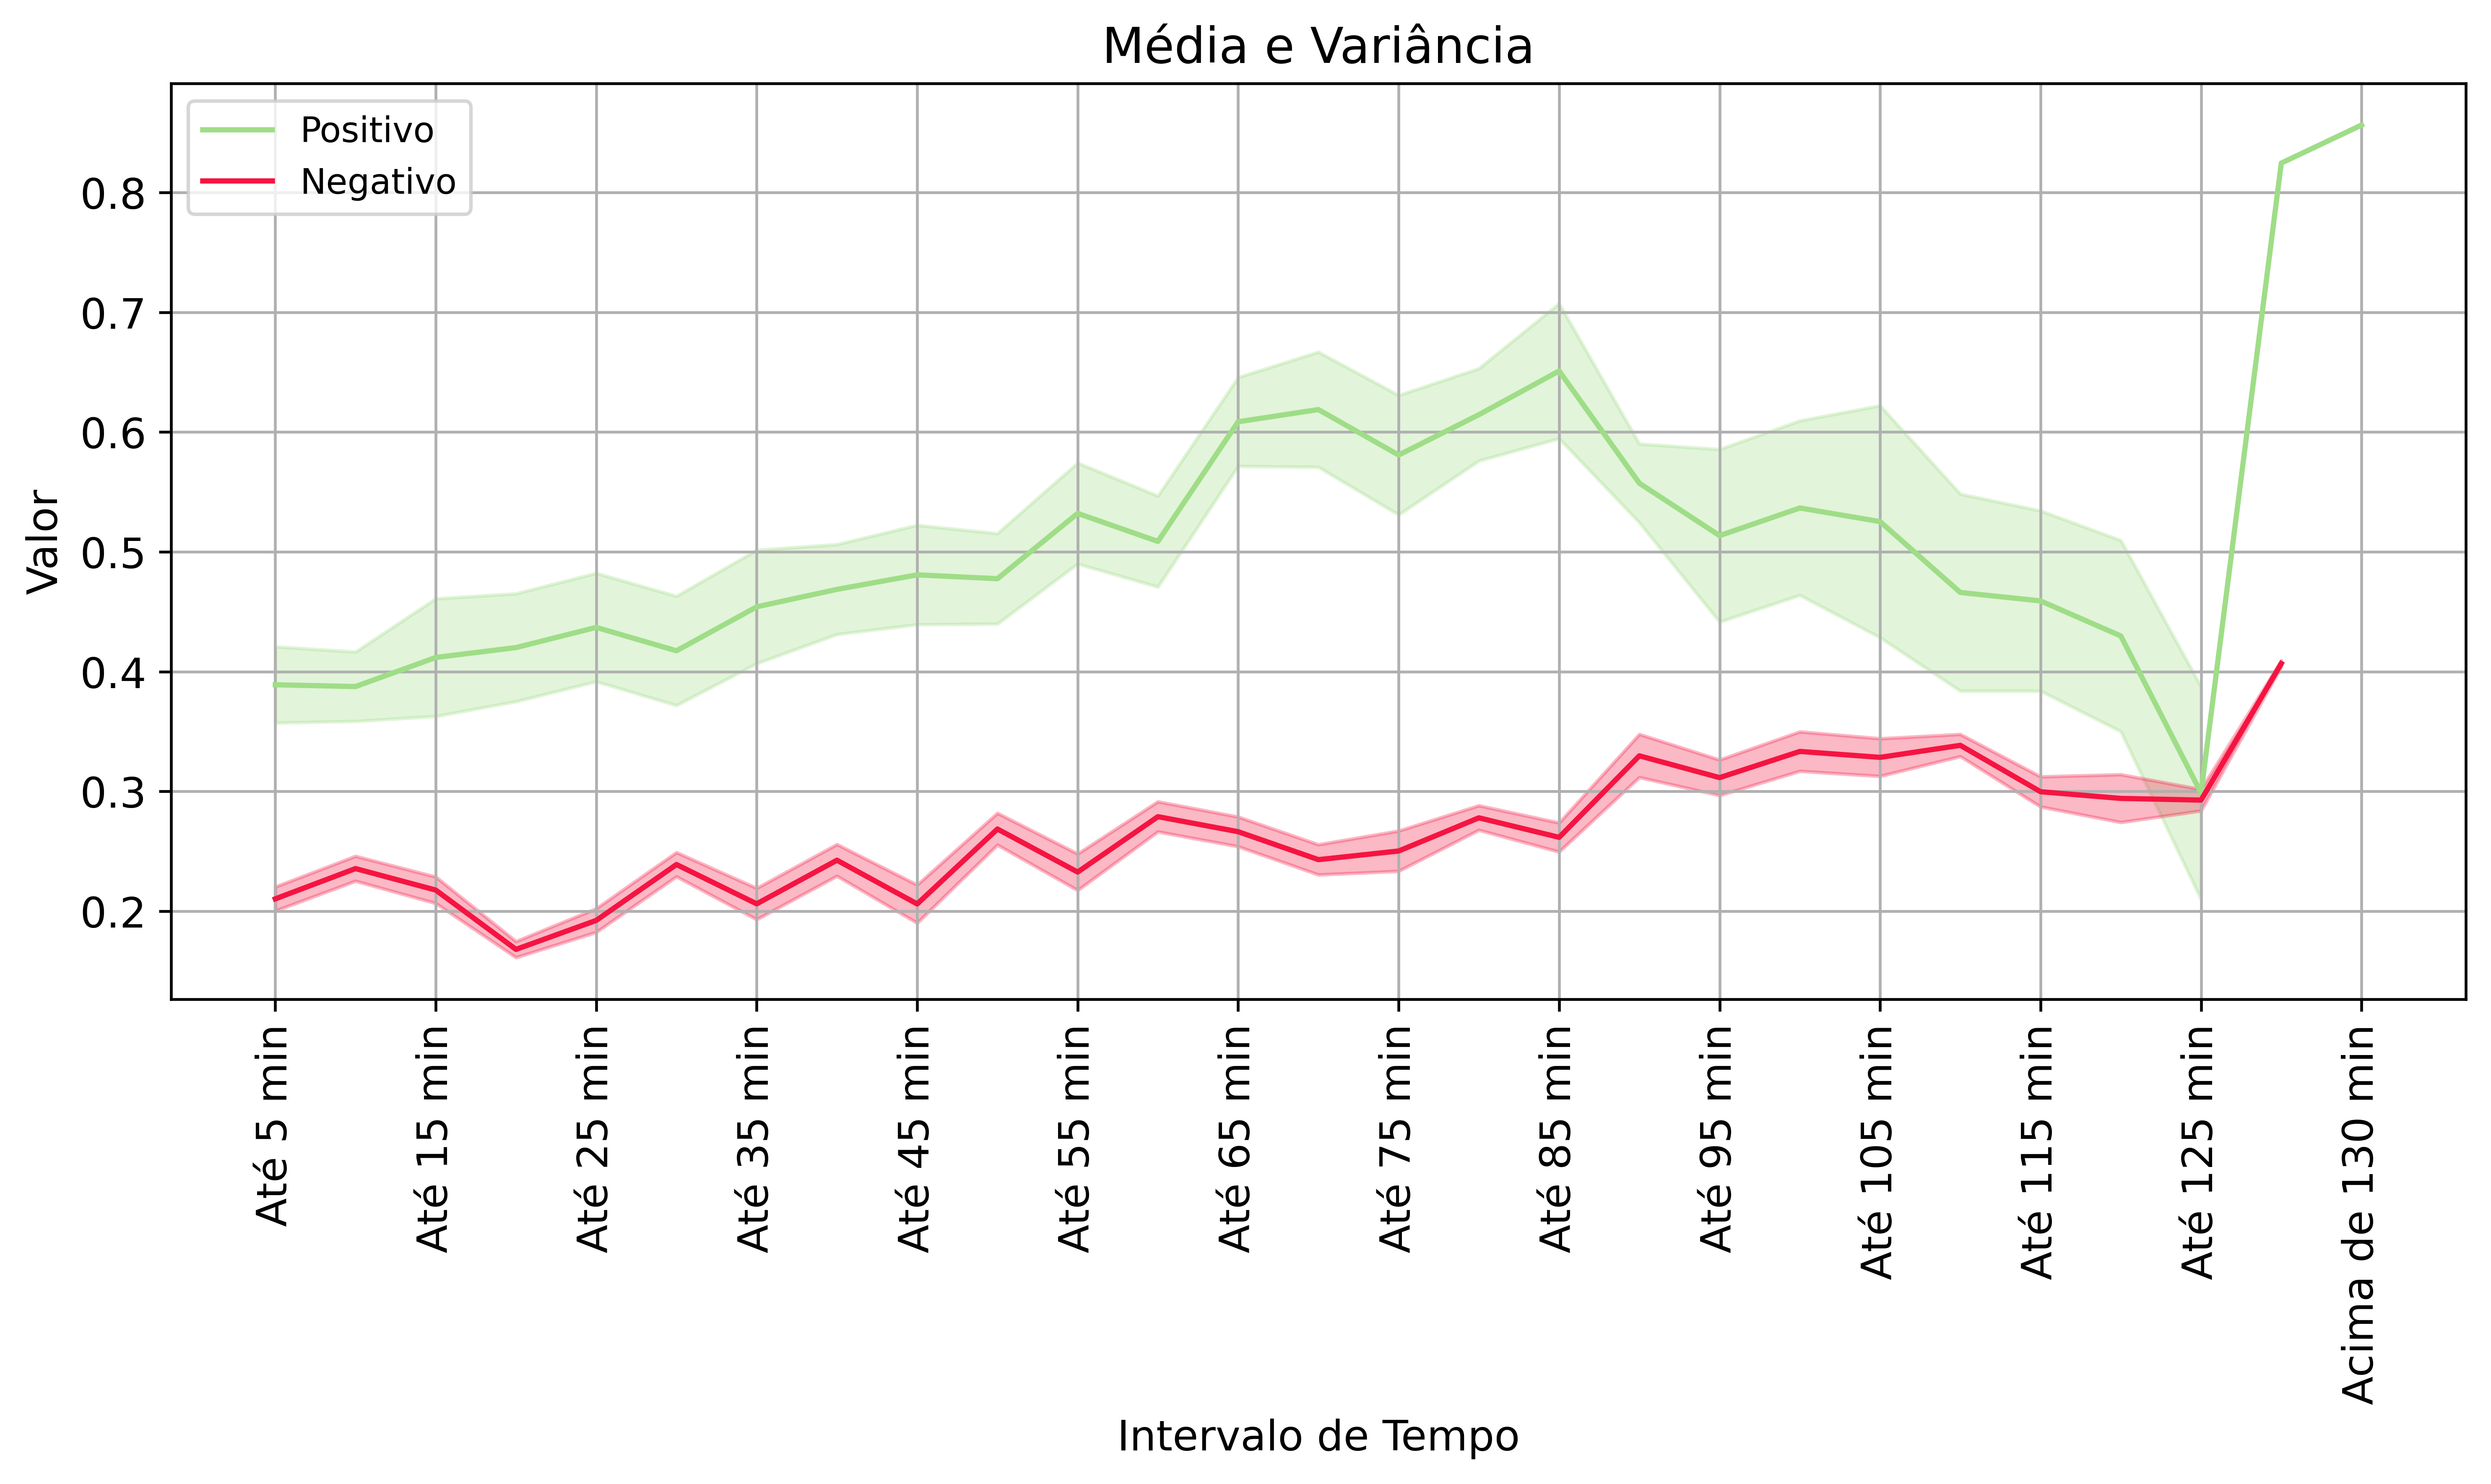

In [52]:
# Filtrar os dados para as classes Positive e Negative
positive_data = df_mean_var[df_mean_var['Alvo'] == 'Positive']
negative_data = df_mean_var[df_mean_var['Alvo'] == 'Negative']

# Calcular média e variância para Valor em relação ao Intervalo_tempo para as duas classes
positive_mean = positive_data.groupby('Intervalo de tempo', observed = False)['Valor'].mean()
positive_var = positive_data.groupby('Intervalo de tempo', observed = False)['Valor'].var()

negative_mean = negative_data.groupby('Intervalo de tempo', observed = False)['Valor'].mean()
negative_var = negative_data.groupby('Intervalo de tempo', observed = False)['Valor'].var()

# Plotar o gráfico de linhas para média e variância de Valor em relação ao Intervalo_tempo
plt.figure(figsize = (10, 6), dpi = 600)

plt.plot(positive_mean, label = 'Positivo', color=green)
plt.plot(negative_mean, label = 'Negativo', color=red)

# Aumentando o tamanho dos números nos eixos x e y
plt.tick_params(axis = 'x', labelsize = 12) 
plt.tick_params(axis = 'y', labelsize = 12)

plt.fill_between(positive_var.index, positive_mean - positive_var, positive_mean + positive_var, alpha = 0.3, color = green)
plt.fill_between(negative_var.index, negative_mean - negative_var, negative_mean + negative_var, alpha = 0.3, color = red)

plt.xlabel('Intervalo de Tempo', fontsize = 12)
plt.ylabel('Valor', fontsize = 12)
plt.title('Média e Variância', fontsize = 14)
plt.legend()
plt.grid(True)
plt.xticks(rotation = 90)  # Rotacionar os rótulos
plt.gca().set_xticks(plt.gca().get_xticks()[::2]) 
plt.tight_layout()

plt.show()

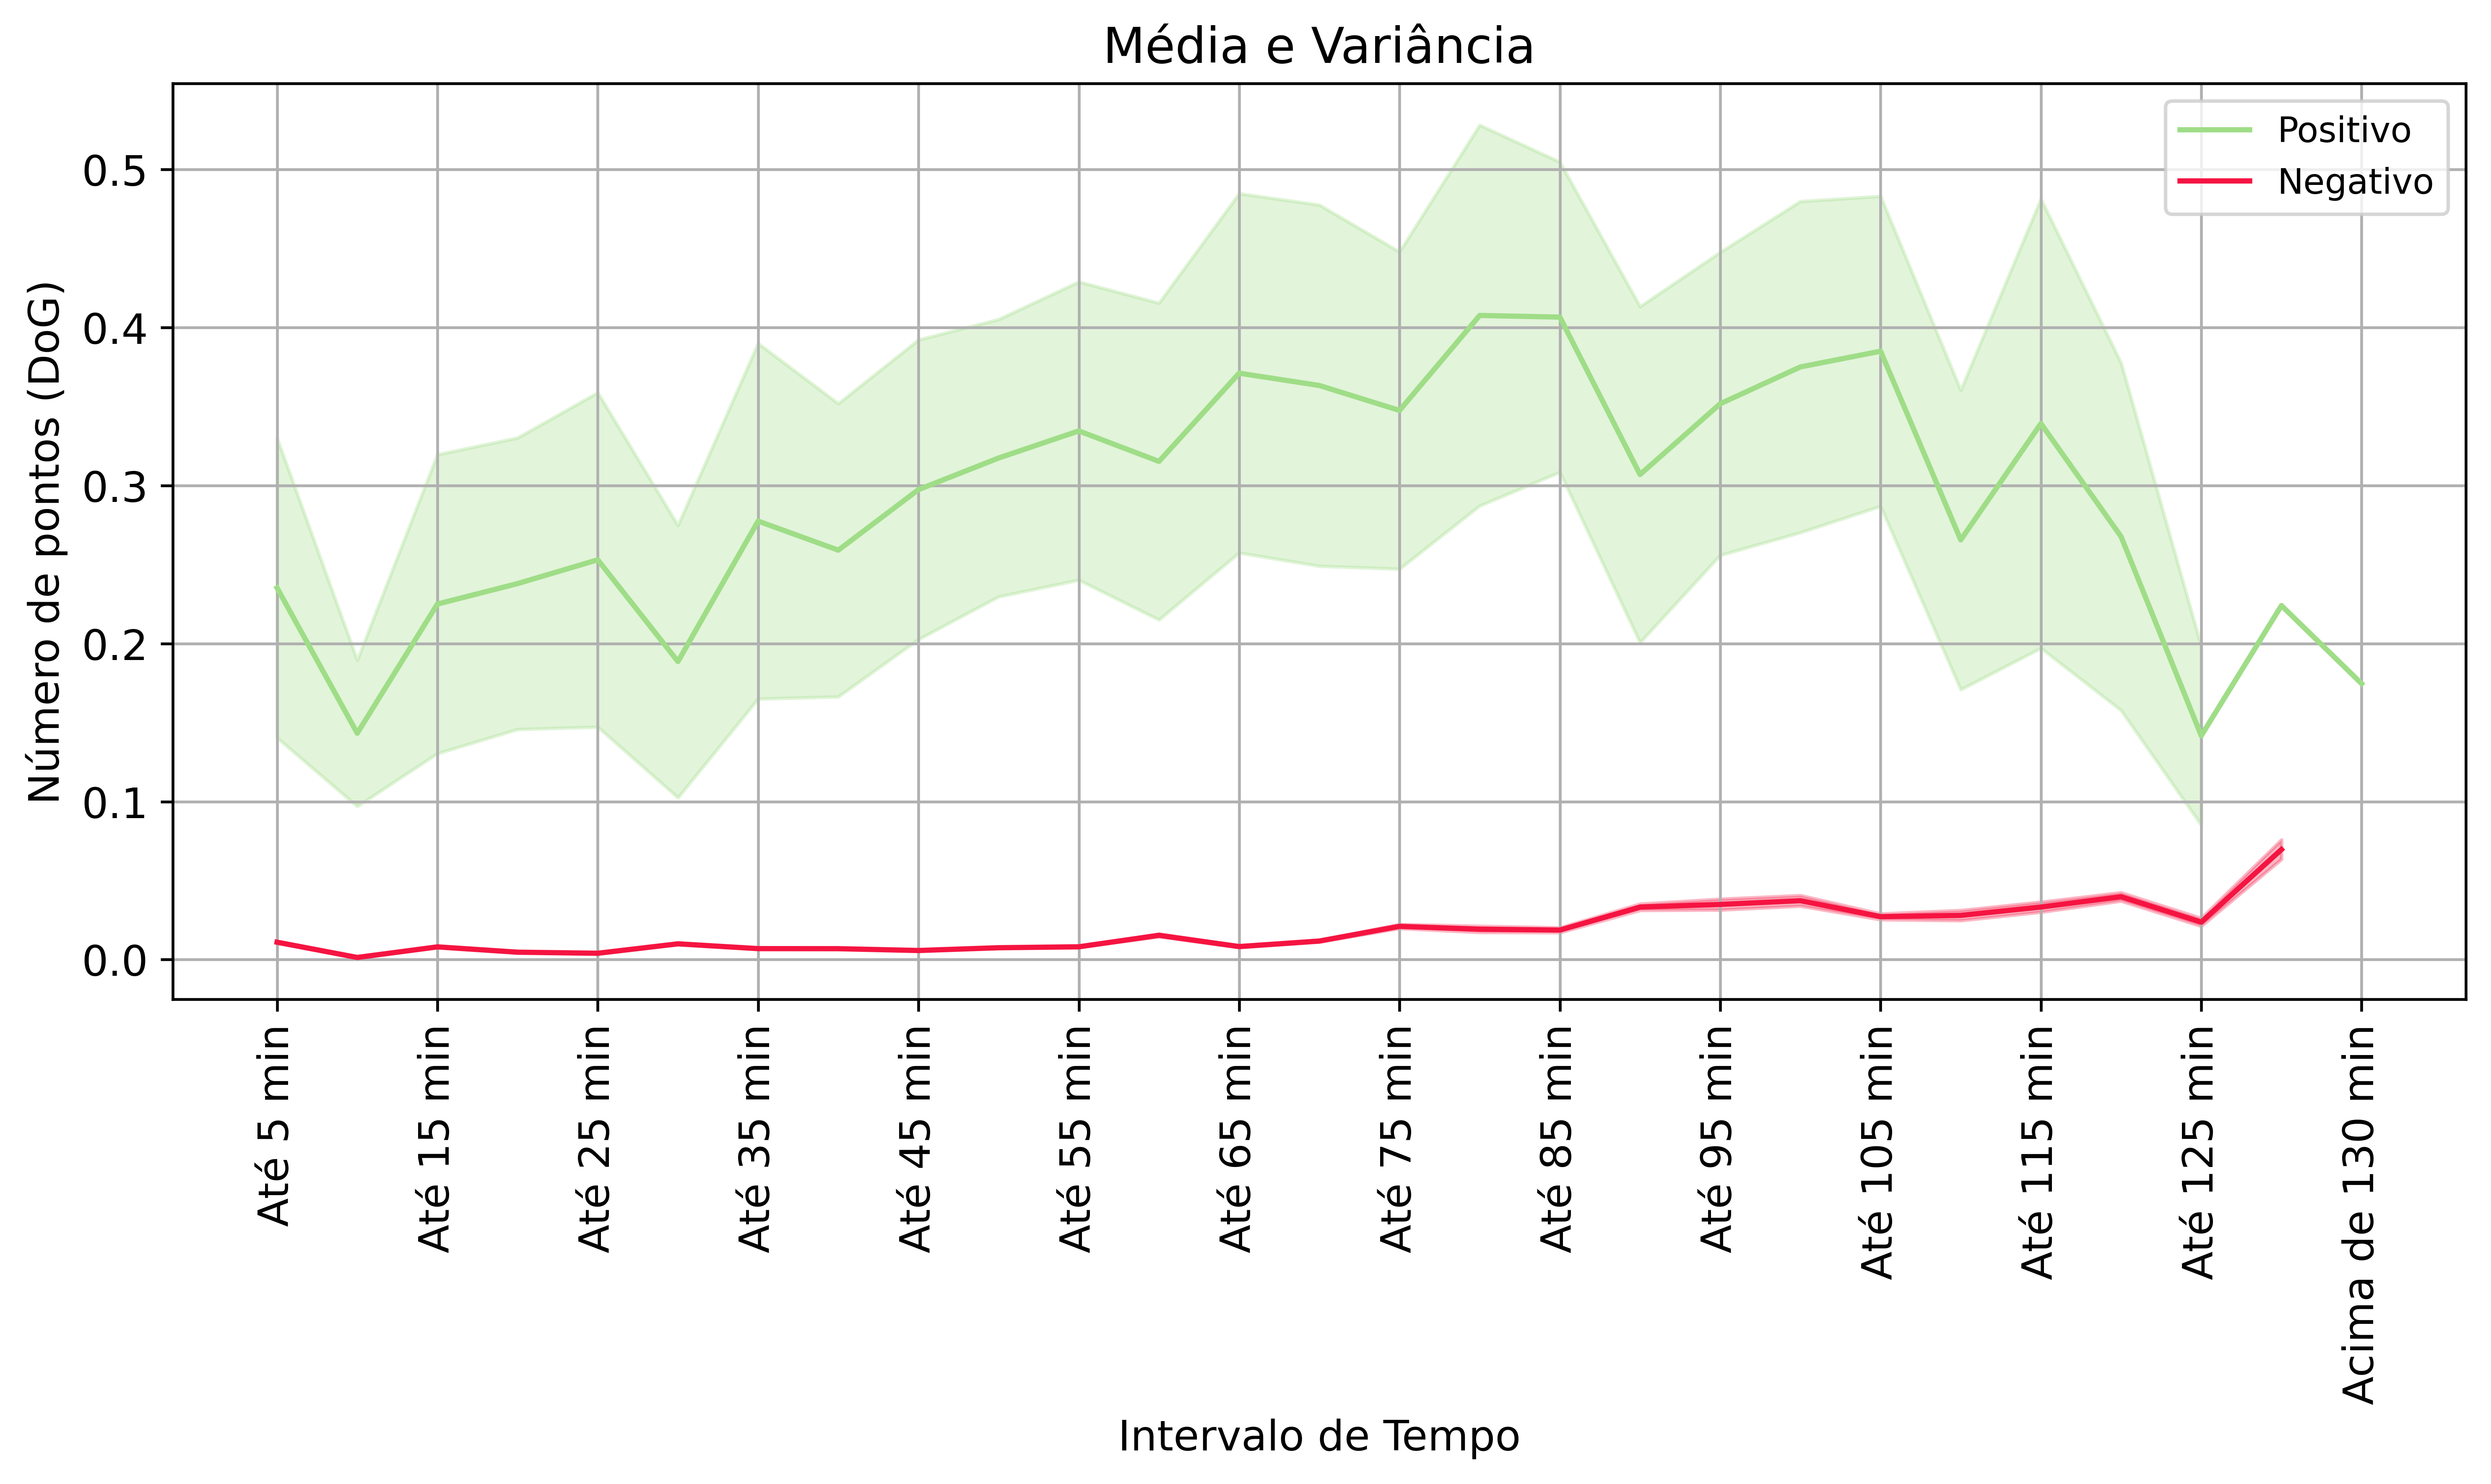

In [54]:
# Filtrar os dados para as classes Positive e Negative
positive_data = df_mean_var[df_mean_var['Alvo'] == 'Positive']
negative_data = df_mean_var[df_mean_var['Alvo'] == 'Negative']

# Calcular média e variância para DoG em relação ao Intervalo_tempo para as duas classes
positive_mean = positive_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (DoG)'].mean()
positive_var = positive_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (DoG)'].var()

negative_mean = negative_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (DoG)'].mean()
negative_var = negative_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (DoG)'].var()

# Plotar o gráfico de linhas para média e variância de DoG em relação ao Intervalo_tempo
plt.figure(figsize = (10, 6), dpi = 600)

plt.plot(positive_mean, label = 'Positivo', color=green)
plt.plot(negative_mean, label = 'Negativo', color=red)

# Aumentando o tamanho dos números nos eixos x e y
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)


plt.fill_between(positive_var.index, positive_mean - positive_var, positive_mean + positive_var, alpha = 0.3, color = green)
plt.fill_between(negative_var.index, negative_mean - negative_var, negative_mean + negative_var, alpha = 0.3, color = red)

plt.xlabel('Intervalo de Tempo', fontsize = 12)
plt.ylabel('Número de pontos (DoG)', fontsize = 12)
plt.title('Média e Variância', fontsize = 14)
plt.legend()
plt.grid(True)
plt.xticks(rotation = 90)  # Rotacionar os rótulos
plt.gca().set_xticks(plt.gca().get_xticks()[::2]) 
plt.tight_layout()

plt.show()

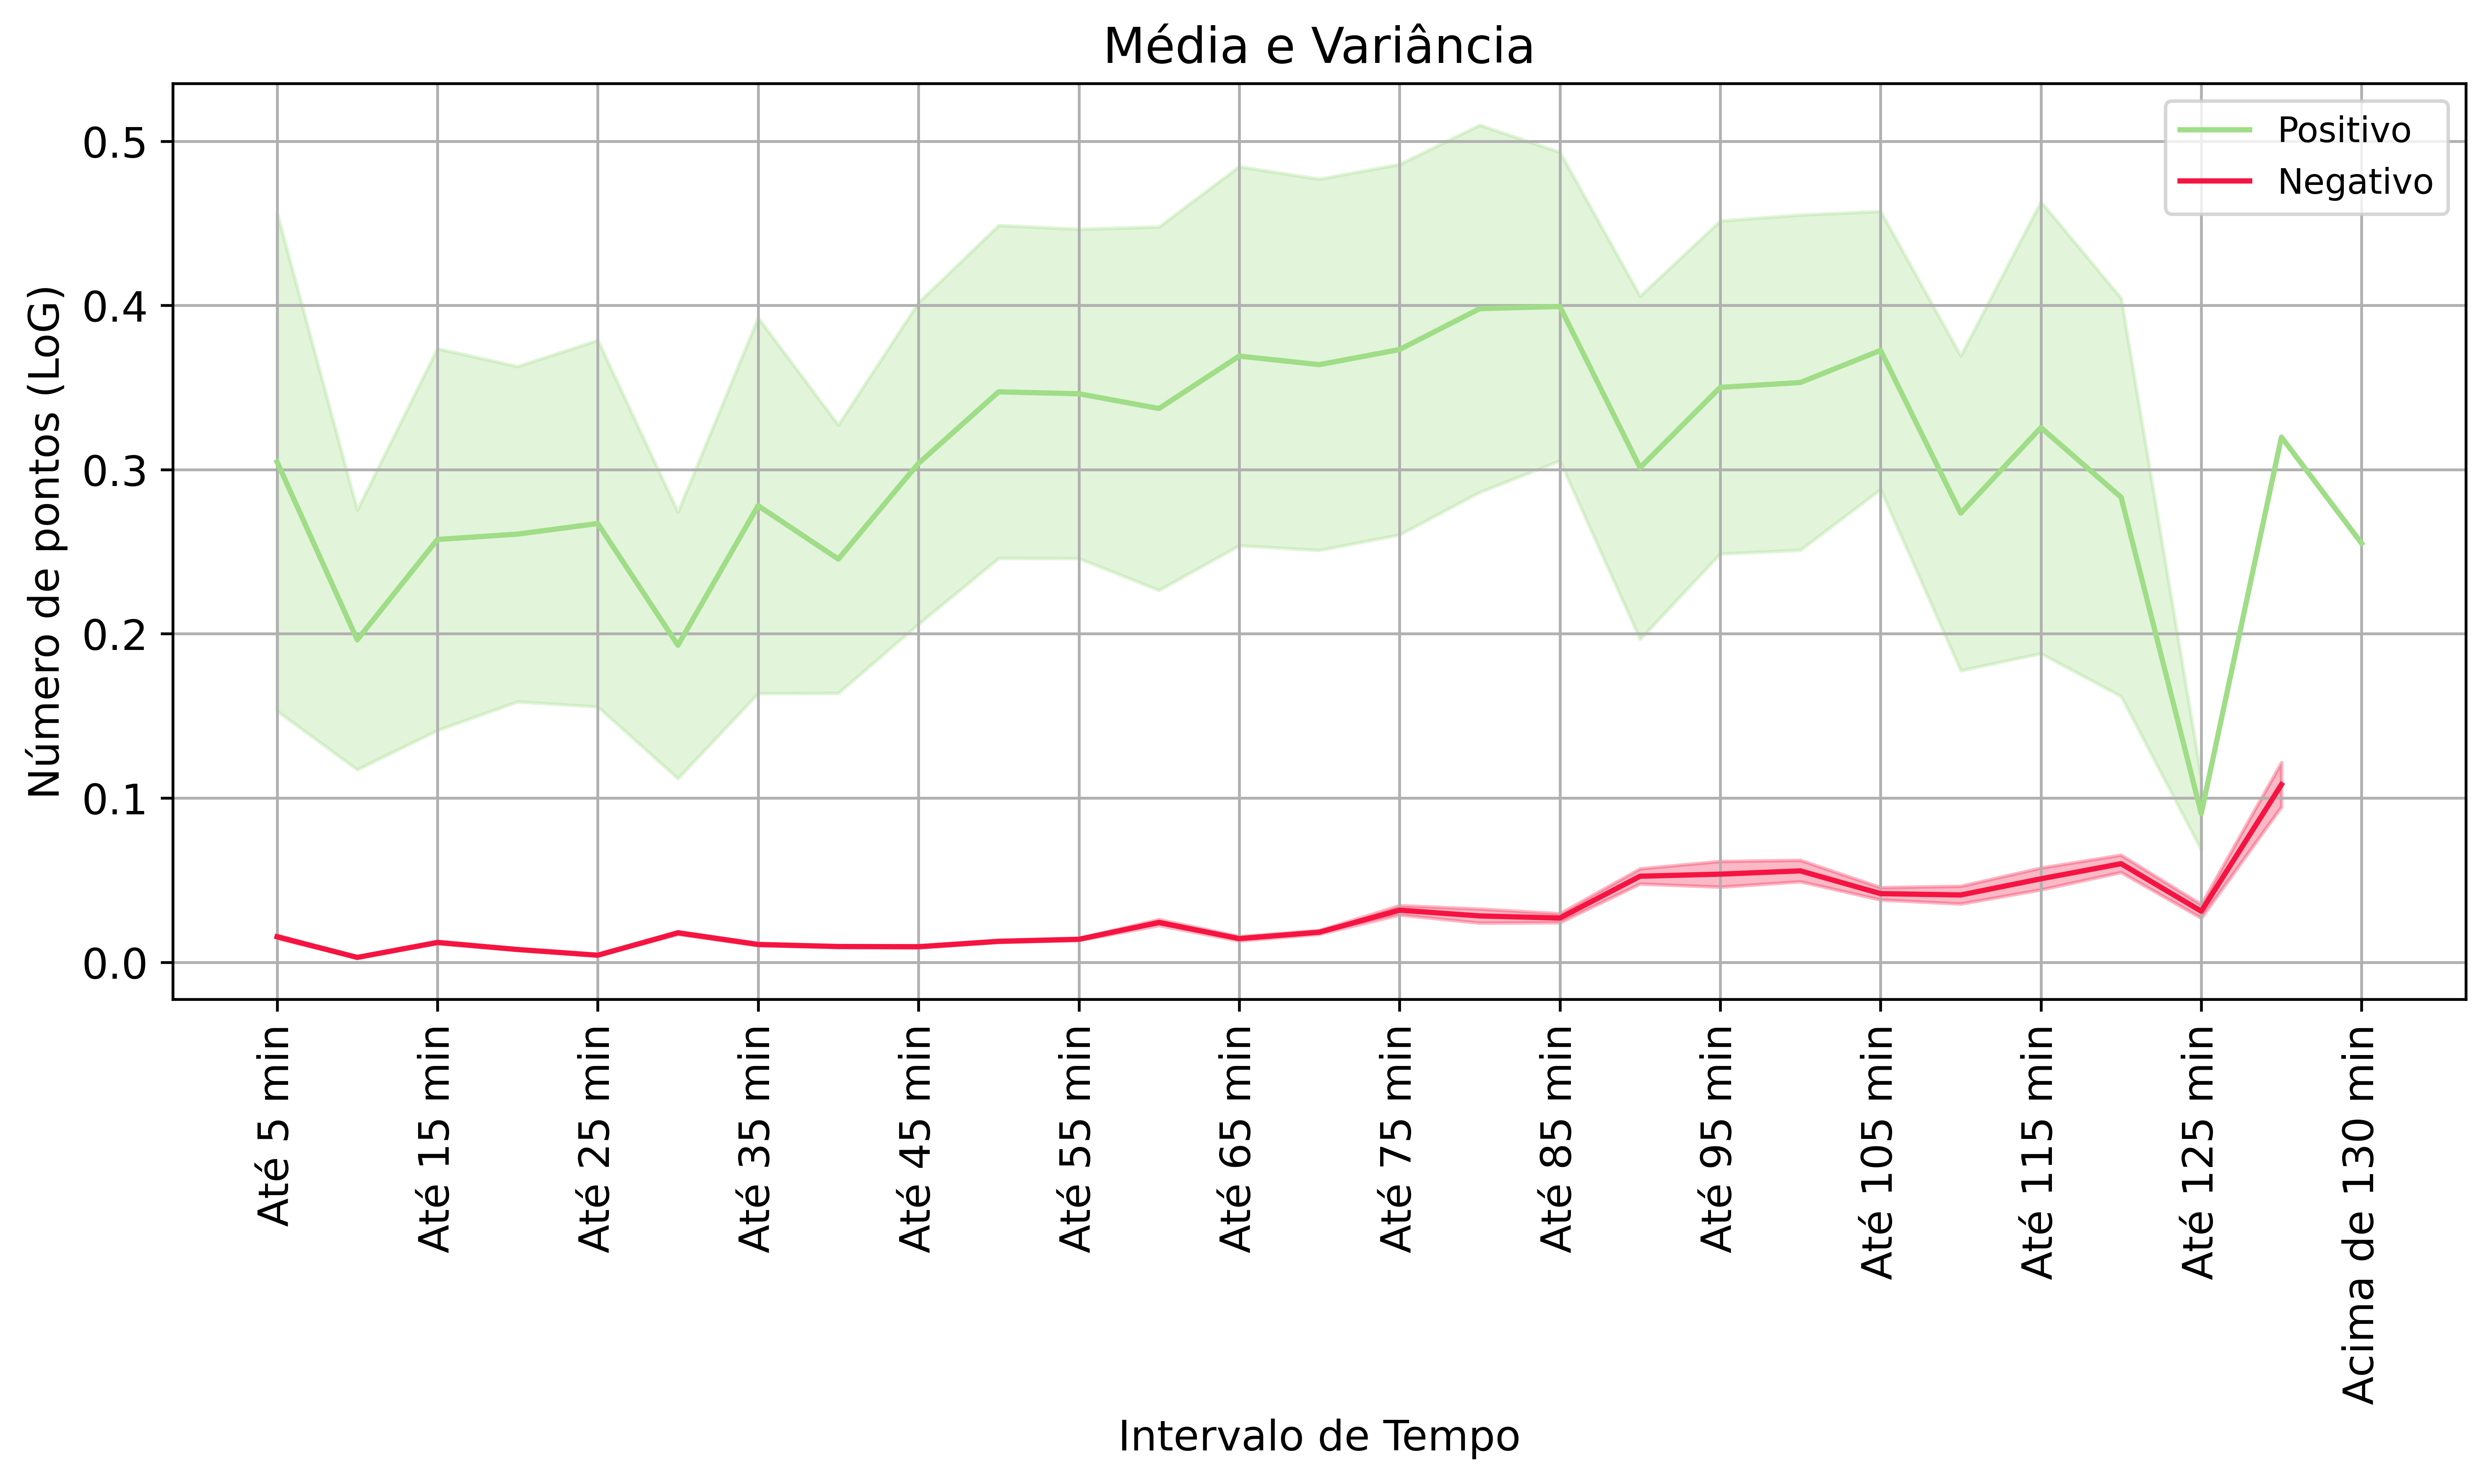

In [53]:
# Filtrar os dados para as classes Positive e Negative
positive_data = df_mean_var[df_mean_var['Alvo'] == 'Positive']
negative_data = df_mean_var[df_mean_var['Alvo'] == 'Negative']

# Calcular média e variância para LoG em relação ao Intervalo_tempo para as duas classes
positive_mean = positive_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (LoG)'].mean()
positive_var = positive_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (LoG)'].var()

negative_mean = negative_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (LoG)'].mean()
negative_var = negative_data.groupby('Intervalo de tempo', observed = False)['Número de pontos (LoG)'].var()

# Plotar o gráfico de linhas para média e variância de LoG em relação ao Intervalo_tempo
plt.figure(figsize = (10, 6), dpi = 600)

plt.plot(positive_mean, label = 'Positivo', color=green)
plt.plot(negative_mean, label = 'Negativo', color=red)

# Aumentando o tamanho dos números nos eixos x e y
plt.tick_params(axis = 'x', labelsize = 12)
plt.tick_params(axis = 'y', labelsize = 12)

plt.fill_between(positive_var.index, positive_mean - positive_var, positive_mean + positive_var, alpha = 0.3, color = green)
plt.fill_between(negative_var.index, negative_mean - negative_var, negative_mean + negative_var, alpha = 0.3, color = red)

plt.xlabel('Intervalo de Tempo', fontsize = 12)
plt.ylabel('Número de pontos (LoG)', fontsize = 12)
plt.title('Média e Variância', fontsize = 14)
plt.legend()
plt.grid(True)
plt.xticks(rotation = 90)  # Rotacionar os rótulos
plt.gca().set_xticks(plt.gca().get_xticks()[::2]) 
plt.tight_layout()

plt.show()

#### GRIDSEARCH

In [35]:
param_grid = [
    {
        'hidden_layer_sizes': [(100,), (110,), (200,)],
        'activation' : ['identity', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd'],
        'alpha' : [0.0001, 0.05, 0.01, 0.005],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [1400, 1500, 1600, 1700, 1800, 1900, 2000]
    }
]

In [37]:
grid = GridSearchCV(modelRNA_Classifier, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X,y)

print("Best parameters set found on development set:")
print(grid.best_params_)

Best parameters set found on development set:
{'activation': 'identity', 'alpha': 0.005, 'hidden_layer_sizes': (110,), 'learning_rate': 'adaptive', 'max_iter': 1500, 'solver': 'lbfgs'}


In [39]:
grid2 = GridSearchCV(modelRNA_Classifier, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid2.fit(X_scaled,y)

print("Best parameters set found on development set:")
print(grid2.best_params_)

Best parameters set found on development set:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (110,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}
